In [1]:
# Install required packages if not already installed
# Uncomment and run this cell if you get ModuleNotFoundError
# !pip install pandas numpy matplotlib scikit-learn
!pip install pandas numpy matplotlib scikit-learn

   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ------------------ --------------------- 5.0/11.0 MB 35.4 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 40.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 8.1/8.1 MB 53.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------------------------------------- 8.7/8.7 MB 57.6 MB/s eta 0:00:00

   ---------------------------------------- 0/3 [scikit-learn]
   ---------------------------------------- 0/3 [scikit-learn]
   ---------------------------------------- 0/3 [scikit-learn]
   ---------------------------------------- 0/3 [scikit-learn]
   ---------------------------------------- 0/3 [scikit-learn]
   ---------------------------------------- 0/3 [scikit-learn]
   ---------------------------------------- 0/3 [scikit-learn]
   ------------------------------------


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'pandas'

In [ ]:
# Load interaction splits
train_df = pd.read_csv("dataset/interactions_train.csv")
val_df = pd.read_csv("dataset/interactions_validation.csv")
test_df = pd.read_csv("dataset/interactions_test.csv")

# Optional: load raw metadata for future use
raw_recipes = pd.read_csv("dataset/RAW_recipes.csv")
raw_interactions = pd.read_csv("dataset/RAW_interactions.csv")

# Preprocessed embeddings (not needed yet)
pp_users = pd.read_csv("dataset/PP_users.csv")
pp_recipes = pd.read_csv("dataset/PP_recipes.csv")

# Exploratory Data Analysis

In [ ]:
train_df.head()

,user_id,recipe_id,date,rating,u,i
0,2046,4684,2000-02-25,5.0,22095,44367
1,2046,517,2000-02-25,5.0,22095,87844
2,1773,7435,2000-03-13,5.0,24732,138181
3,1773,278,2000-03-13,4.0,24732,93054
4,2046,3431,2000-04-07,5.0,22095,101723


In [ ]:
train_df.info()
train_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698901 entries, 0 to 698900
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    698901 non-null  int64  
 1   recipe_id  698901 non-null  int64  
 2   date       698901 non-null  object 
 3   rating     698901 non-null  float64
 4   u          698901 non-null  int64  
 5   i          698901 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 32.0+ MB


,user_id,recipe_id,rating,u,i
count,6.989010e+05,698901.000000,698901.000000,698901.000000,698901.000000
mean,1.247694e+07,156173.409849,4.574090,4249.330271,87519.330993
std,1.525031e+08,126594.880211,0.959022,5522.602821,51290.370370
min,1.533000e+03,38.000000,0.000000,0.000000,0.000000
25%,1.059880e+05,53169.000000,4.000000,455.000000,42988.000000
50%,2.301020e+05,116484.000000,5.000000,1737.000000,87424.000000
75%,4.801950e+05,234516.000000,5.000000,5919.000000,131731.000000
max,2.002313e+09,537458.000000,5.000000,25075.000000,178262.000000


## Distribution of Recipe Ratings

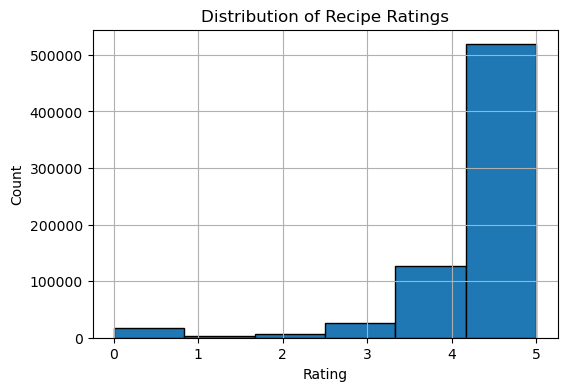

In [ ]:
plt.figure(figsize=(6,4))
train_df['rating'].hist(bins=6, edgecolor='black')
plt.title("Distribution of Recipe Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

The distribution of ratings in the dataset is heavily skewed toward the positive end of the scale. Ratings of 4 and 5 stars dominate the dataset, with 5-star ratings forming a noticeable spike. This suggests that users tend to leave high ratings for recipes they try, which is consistent with user behavior on recipe platforms—people often cook recipes they expect to enjoy and are more motivated to provide feedback when the outcome is favorable.

Interestingly, while ratings of 1 and 2 stars are rare, the number of 0-star ratings is noticeably higher than both 1 and 2 stars. In fact, 0-star ratings are closer in frequency to 3-star ratings than to the lower end of the scale. This suggests that users may assign a 0 rating deliberately to express strong dissatisfaction, rather than using intermediate low values like 1 or 2. As a result, the distribution forms a somewhat smooth curve from 1–5, but with a bimodal shape at the extremes: a large concentration at 5 stars, and an unnatural bump at 0.

This behavior has important implications for model design:

- The dominance of high ratings means that predicting the mean rating is not a useful baseline—a trivial model could appear accurate without making meaningful recommendations.

- Because the data is not evenly distributed across the rating scale, metrics like MSE can be misleading.

- Instead, ranking-based evaluation metrics (e.g., Precision@K, Recall@K, MRR) are more appropriate for this dataset, as they focus on how well a model orders preferred recipes rather than how close it gets to numeric ratings.

Overall, this positive and somewhat polarized rating behavior provides a strong motivation for using ranking-based recommender models rather than simple rating prediction approaches.

## Distribution of Ratings per User

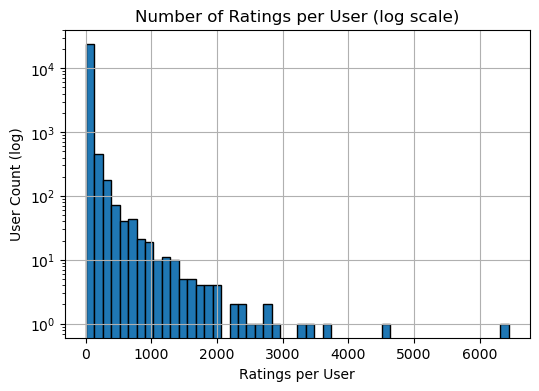

count    25076.000000
mean        27.871311
std        122.729039
min          2.000000
25%          3.000000
50%          6.000000
75%         16.000000
max       6437.000000
dtype: float64

In [ ]:
user_counts = train_df.groupby('u').size()

plt.figure(figsize=(6,4))
user_counts.hist(bins=50, log=True, edgecolor='black')
plt.title("Number of Ratings per User (log scale)")
plt.xlabel("Ratings per User")
plt.ylabel("User Count (log)")
plt.show()

user_counts.describe()

The distribution of user activity displays an extreme long-tail pattern. While a small number of users have rated hundreds or even thousands of recipes, the vast majority have contributed only a handful of ratings. This is typical of user-generated content platforms: most users interact casually, whereas a small subset of so-called power users engage extensively.

Because the y-axis is plotted on a logarithmic scale, we can clearly see the steep drop-off in participation. The dataset contains many users who have rated fewer than 10 recipes, and progressively fewer users as the number of ratings increases. Only a tiny fraction exceed 1,000 ratings, and some appear to rate over 6,000 recipes, indicating extremely active contributors.

This imbalance has meaningful implications for model training:

- Sparse user histories make it difficult for the model to learn stable preference patterns for many users.

- Power users may disproportionately influence learned embeddings if the model is not properly regularized.

- Techniques such as latent factor models, which generalize user preferences through shared structure, are well-suited to handle this kind of interaction sparsity.

Overall, the user activity distribution underscores the importance of collaborative approaches that leverage patterns across users, rather than relying solely on individual histories.

## Distribution of Ratings per Recipe

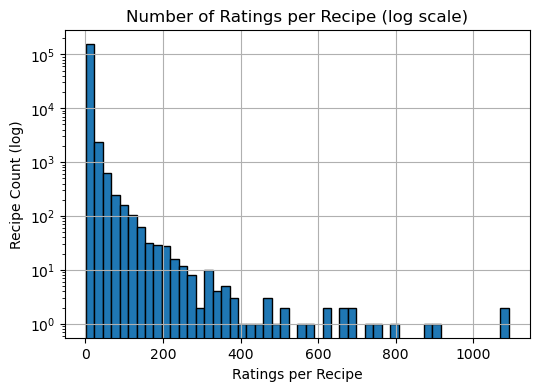

count    160901.000000
mean          4.343671
std          13.421461
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max        1091.000000
dtype: float64

In [ ]:
item_counts = train_df.groupby('i').size()

plt.figure(figsize=(6,4))
item_counts.hist(bins=50, log=True, edgecolor='black')
plt.title("Number of Ratings per Recipe (log scale)")
plt.xlabel("Ratings per Recipe")
plt.ylabel("Recipe Count (log)")
plt.show()

item_counts.describe()

The distribution of recipe popularity shows an even stronger long-tail effect than user activity. Most recipes receive very few ratings, while a small number accumulate hundreds or even over 1,000 ratings. Once again, the use of a logarithmic scale reveals this imbalance clearly: a large proportion of recipes appear only once or twice in the dataset, whereas only a handful receive widespread attention.

This structure is typical of domains with expansive item catalogs, where new or niche items receive little engagement. For recommender systems, this creates a challenge known as the item cold-start problem: many recipes lack enough historical data for the model to learn their characteristics well.

From a modeling standpoint, this motivates the use of techniques that incorporate additional recipe features—such as ingredients, cooking time, tags, or nutritional attributes—to supplement sparse interaction histories. Later extensions to collaborative filtering or factorization models can leverage this metadata to improve recommendations for less frequently rated recipes.

In summary, the long-tail nature of recipe ratings demonstrates both the difficulty and necessity of a recommendation model capable of generalizing from limited item-specific data.

## Sparsity of the Interaction Matrix

In [ ]:
n_users = train_df['u'].nunique()
n_items = train_df['i'].nunique()
n_interactions = len(train_df)

sparsity = 1 - n_interactions / (n_users * n_items)
sparsity

0.9998267797514377

The combination of a large number of users, a large number of recipes, and relatively few observed interactions produces an interaction matrix that is extremely sparse. In other words, the vast majority of possible user–recipe pairs have no recorded rating. High sparsity is characteristic of recommendation datasets and directly motivates the use of models such as collaborative filtering and matrix factorization, which exploit shared patterns across users and items to predict missing entries.

# Baseline Recommenders

We implement three simple baseline models to establish a performance baseline for comparison with more advanced models:

1. **Popularity Recommender**: Recommends the most-rated recipes (non-personalized)
2. **User Mean Predictor**: Predicts based on user's average rating
3. **Item Mean Predictor**: Predicts based on recipe's average rating


In [ ]:
## Baseline 1: Popularity Recommender

class PopularityRecommender:
    """
    Recommends recipes based on popularity (number of ratings).
    All users receive the same recommendations (non-personalized).
    """
    
    def __init__(self):
        self.popular_recipes = None
        self.recipe_counts = None
    
    def fit(self, train_df):
        """
        Fit the model by counting ratings per recipe and sorting by popularity.
        
        Parameters:
        -----------
        train_df : pd.DataFrame
            Training data with columns ['recipe_id', 'rating', 'i']
        """
        # Count how many times each recipe was rated
        # Use 'i' (item index) for consistency with other models
        self.recipe_counts = train_df.groupby('i').size().reset_index(name='count')
        
        # Sort by count descending (most popular first)
        self.recipe_counts = self.recipe_counts.sort_values('count', ascending=False)
        
        # Store list of popular recipes (item indices)
        self.popular_recipes = self.recipe_counts['i'].values
        
        print(f"Fitted PopularityRecommender on {len(self.popular_recipes)} recipes")
        print(f"Most popular recipe (index {self.popular_recipes[0]}) has {self.recipe_counts.iloc[0]['count']} ratings")
    
    def recommend(self, user_id, k=10):
        """
        Recommend top K most popular recipes.
        Same recommendations for all users (non-personalized).
        
        Parameters:
        -----------
        user_id : int
            User ID (ignored, same recommendations for all)
        k : int
            Number of recommendations to return
            
        Returns:
        --------
        list : Top K recipe indices (item indices 'i')
        """
        if self.popular_recipes is None:
            raise ValueError("Model must be fitted before making recommendations")
        
        return self.popular_recipes[:k].tolist()
    
    def predict(self, user_id, recipe_id):
        """
        Predict rating based on recipe popularity.
        Returns the count of ratings for the recipe (higher = more popular).
        
        Parameters:
        -----------
        user_id : int
            User ID (ignored)
        recipe_id : int
            Recipe ID (needs to be converted to item index 'i')
            
        Returns:
        --------
        float : Popularity score (count of ratings)
        """
        if self.recipe_counts is None:
            raise ValueError("Model must be fitted before making predictions")
        
        # Find recipe in popular list
        recipe_row = self.recipe_counts[self.recipe_counts['i'] == recipe_id]
        
        if len(recipe_row) == 0:
            # Recipe not seen in training, return 0
            return 0.0
        
        return float(recipe_row.iloc[0]['count'])


In [ ]:
# Test Popularity Recommender
pop_recommender = PopularityRecommender()
pop_recommender.fit(train_df)

# Test recommendation for a user
test_user = train_df['u'].iloc[0]
recommendations = pop_recommender.recommend(test_user, k=10)
print(f"\nTop 10 popular recipes (indices): {recommendations}")

# Show top 5 most popular recipes with their counts
print("\nTop 5 most popular recipes:")
print(pop_recommender.recipe_counts.head())


In [ ]:
## Baseline 2: User Mean Predictor

class UserMeanPredictor:
    """
    Predicts ratings based on user's average rating.
    All recipes for a user get the same predicted rating (user's mean).
    """
    
    def __init__(self):
        self.user_means = None
    
    def fit(self, train_df):
        """
        Fit the model by calculating mean rating for each user.
        
        Parameters:
        -----------
        train_df : pd.DataFrame
            Training data with columns ['u', 'rating']
        """
        # Calculate mean rating for each user (using 'u' index)
        self.user_means = train_df.groupby('u')['rating'].mean().to_dict()
        
        # Calculate global mean for users not in training
        self.global_mean = train_df['rating'].mean()
        
        print(f"Fitted UserMeanPredictor on {len(self.user_means)} users")
        print(f"Global mean rating: {self.global_mean:.3f}")
        print(f"User mean range: {min(self.user_means.values()):.3f} to {max(self.user_means.values()):.3f}")
    
    def predict(self, user_id, recipe_id):
        """
        Predict rating as user's mean rating (same for all recipes).
        
        Parameters:
        -----------
        user_id : int
            User index 'u'
        recipe_id : int
            Recipe ID (ignored, prediction is user-specific only)
            
        Returns:
        --------
        float : User's mean rating, or global mean if user not seen
        """
        if self.user_means is None:
            raise ValueError("Model must be fitted before making predictions")
        
        return self.user_means.get(user_id, self.global_mean)
    
    def recommend(self, user_id, all_recipes, k=10):
        """
        Recommend recipes for a user.
        Since all recipes have the same predicted rating (user's mean),
        we return any K recipes (not personalized).
        
        Parameters:
        -----------
        user_id : int
            User index 'u'
        all_recipes : list or array
            List of all recipe indices to choose from
        k : int
            Number of recommendations to return
            
        Returns:
        --------
        list : K recipe indices (arbitrary selection since all have same score)
        """
        if self.user_means is None:
            raise ValueError("Model must be fitted before making recommendations")
        
        # Convert to list if needed
        if isinstance(all_recipes, (np.ndarray, pd.Series)):
            all_recipes = all_recipes.tolist()
        
        # Return first K recipes (all have same predicted rating)
        return all_recipes[:k]


In [ ]:
# Test User Mean Predictor
user_mean_predictor = UserMeanPredictor()
user_mean_predictor.fit(train_df)

# Test prediction for a user-recipe pair
test_user = train_df['u'].iloc[0]
test_recipe = train_df['i'].iloc[0]
prediction = user_mean_predictor.predict(test_user, test_recipe)
print(f"Predicted rating for user {test_user}, recipe {test_recipe}: {prediction:.3f}")

# Check actual user mean
actual_mean = train_df[train_df['u'] == test_user]['rating'].mean()
print(f"Actual user mean: {actual_mean:.3f}")

# Test recommendation
all_recipes = train_df['i'].unique()[:100]  # Sample of recipes
recommendations = user_mean_predictor.recommend(test_user, all_recipes, k=10)
print(f"\nRecommendations (first 10 recipes): {recommendations}")


In [ ]:
## Baseline 3: Item Mean Predictor

class ItemMeanPredictor:
    """
    Predicts ratings based on recipe's average rating.
    All users get the same predicted rating for a recipe (recipe's mean).
    """
    
    def __init__(self):
        self.item_means = None
        self.sorted_recipes = None
    
    def fit(self, train_df):
        """
        Fit the model by calculating mean rating for each recipe.
        
        Parameters:
        -----------
        train_df : pd.DataFrame
            Training data with columns ['i', 'rating']
        """
        # Calculate mean rating for each recipe (using 'i' index)
        item_stats = train_df.groupby('i')['rating'].agg(['mean', 'count']).reset_index()
        item_stats.columns = ['i', 'mean_rating', 'count']
        
        # Store as dictionary for fast lookup
        self.item_means = item_stats.set_index('i')['mean_rating'].to_dict()
        
        # Sort recipes by mean rating (best first) for recommendations
        self.sorted_recipes = item_stats.sort_values('mean_rating', ascending=False)['i'].values
        
        # Calculate global mean for recipes not in training
        self.global_mean = train_df['rating'].mean()
        
        print(f"Fitted ItemMeanPredictor on {len(self.item_means)} recipes")
        print(f"Global mean rating: {self.global_mean:.3f}")
        print(f"Recipe mean range: {min(self.item_means.values()):.3f} to {max(self.item_means.values()):.3f}")
    
    def predict(self, user_id, recipe_id):
        """
        Predict rating as recipe's mean rating (same for all users).
        
        Parameters:
        -----------
        user_id : int
            User ID (ignored, prediction is recipe-specific only)
        recipe_id : int
            Recipe index 'i'
            
        Returns:
        --------
        float : Recipe's mean rating, or global mean if recipe not seen
        """
        if self.item_means is None:
            raise ValueError("Model must be fitted before making predictions")
        
        return self.item_means.get(recipe_id, self.global_mean)
    
    def recommend(self, user_id, k=10):
        """
        Recommend top K recipes sorted by their mean rating.
        Same recommendations for all users (non-personalized).
        
        Parameters:
        -----------
        user_id : int
            User ID (ignored, same recommendations for all)
        k : int
            Number of recommendations to return
            
        Returns:
        --------
        list : Top K recipe indices sorted by mean rating
        """
        if self.sorted_recipes is None:
            raise ValueError("Model must be fitted before making recommendations")
        
        return self.sorted_recipes[:k].tolist()


In [ ]:
# Test Item Mean Predictor
item_mean_predictor = ItemMeanPredictor()
item_mean_predictor.fit(train_df)

# Test prediction for a user-recipe pair
test_user = train_df['u'].iloc[0]
test_recipe = train_df['i'].iloc[0]
prediction = item_mean_predictor.predict(test_user, test_recipe)
print(f"Predicted rating for user {test_user}, recipe {test_recipe}: {prediction:.3f}")

# Check actual recipe mean
actual_mean = train_df[train_df['i'] == test_recipe]['rating'].mean()
print(f"Actual recipe mean: {actual_mean:.3f}")

# Test recommendation
recommendations = item_mean_predictor.recommend(test_user, k=10)
print(f"\nTop 10 recipes by mean rating (indices): {recommendations}")

# Show top 5 recipes with their mean ratings
print("\nTop 5 recipes by mean rating:")
top_recipes = train_df.groupby('i')['rating'].agg(['mean', 'count']).reset_index()
top_recipes.columns = ['i', 'mean_rating', 'count']
top_recipes = top_recipes.sort_values('mean_rating', ascending=False).head()
print(top_recipes)


## Baseline Testing on Validation Set

We test that all baselines can generate predictions and recommendations on the validation set.


In [ ]:
# Test all baselines on validation set

print("=" * 60)
print("Testing Baselines on Validation Set")
print("=" * 60)

# Get sample from validation set
val_sample = val_df.head(10)

print("\n1. Popularity Recommender:")
for idx, row in val_sample.iterrows():
    user_id = row['u']
    recipe_id = row['i']
    actual_rating = row['rating']
    pred_popularity = pop_recommender.predict(user_id, recipe_id)
    print(f"  User {user_id}, Recipe {recipe_id}: Actual={actual_rating:.1f}, Popularity={pred_popularity:.0f}")

print("\n2. User Mean Predictor:")
for idx, row in val_sample.iterrows():
    user_id = row['u']
    recipe_id = row['i']
    actual_rating = row['rating']
    pred_rating = user_mean_predictor.predict(user_id, recipe_id)
    print(f"  User {user_id}, Recipe {recipe_id}: Actual={actual_rating:.1f}, Predicted={pred_rating:.3f}")

print("\n3. Item Mean Predictor:")
for idx, row in val_sample.iterrows():
    user_id = row['u']
    recipe_id = row['i']
    actual_rating = row['rating']
    pred_rating = item_mean_predictor.predict(user_id, recipe_id)
    print(f"  User {user_id}, Recipe {recipe_id}: Actual={actual_rating:.1f}, Predicted={pred_rating:.3f}")

print("\n" + "=" * 60)
print("All baselines successfully generate predictions!")
print("=" * 60)


In [ ]:
# Test recommendation generation for all baselines

test_user = val_df['u'].iloc[0]
print(f"Testing recommendations for user {test_user}:\n")

print("1. Popularity Recommender (top 5):")
pop_recs = pop_recommender.recommend(test_user, k=5)
print(f"   {pop_recs}")

print("\n2. User Mean Predictor (top 5 from sample):")
all_recipes_sample = train_df['i'].unique()[:50]
user_recs = user_mean_predictor.recommend(test_user, all_recipes_sample, k=5)
print(f"   {user_recs}")

print("\n3. Item Mean Predictor (top 5):")
item_recs = item_mean_predictor.recommend(test_user, k=5)
print(f"   {item_recs}")

print("\n✓ All baselines can generate recommendations!")


## Baseline Summary

**Popularity Recommender:**
- Non-personalized: All users get same recommendations
- Recommends most-rated recipes
- Simple and fast

**User Mean Predictor:**
- User-specific: Predicts based on user's average rating
- All recipes for a user get same prediction
- Captures user bias (some users rate higher/lower)

**Item Mean Predictor:**
- Recipe-specific: Predicts based on recipe's average rating
- All users get same prediction for a recipe
- Captures recipe quality (some recipes are generally better)

**Next Steps:**
- Implement ranking-based evaluation metrics (Precision@K, Recall@K, MRR, NDCG)
- Compare baselines on validation/test sets
- Build advanced models (Matrix Factorization, BPR) that should outperform these baselines


# Evaluation Framework

We implement ranking-based evaluation metrics to measure how well our models recommend recipes. Since ratings are heavily skewed (avg 4.57), we focus on ranking quality rather than rating prediction accuracy.

**Key Metrics:**
- **Precision@K**: Fraction of top-K recommendations that are relevant
- **Recall@K**: Fraction of relevant items found in top-K
- **MRR**: Mean Reciprocal Rank (position of first relevant item)
- **NDCG@K**: Normalized Discounted Cumulative Gain (quality of ranking order)


In [ ]:
## Ranking Metrics Implementation

def precision_at_k(recommended, relevant, k):
    """
    Calculate Precision@K: fraction of top-K recommendations that are relevant.
    
    Parameters:
    -----------
    recommended : list
        List of recommended item indices
    relevant : set
        Set of relevant item indices (ground truth)
    k : int
        Number of top recommendations to consider
        
    Returns:
    --------
    float : Precision@K (0.0 to 1.0)
    """
    if k == 0 or len(recommended) == 0:
        return 0.0
    
    # Get top-K recommendations
    top_k = recommended[:k]
    
    # Count how many are relevant
    relevant_count = sum(1 for item in top_k if item in relevant)
    
    return relevant_count / min(k, len(recommended))


def recall_at_k(recommended, relevant, k):
    """
    Calculate Recall@K: fraction of relevant items found in top-K.
    
    Parameters:
    -----------
    recommended : list
        List of recommended item indices
    relevant : set
        Set of relevant item indices (ground truth)
    k : int
        Number of top recommendations to consider
        
    Returns:
    --------
    float : Recall@K (0.0 to 1.0)
    """
    if len(relevant) == 0:
        return 0.0
    
    if k == 0 or len(recommended) == 0:
        return 0.0
    
    # Get top-K recommendations
    top_k = recommended[:k]
    
    # Count how many relevant items are in top-K
    relevant_found = sum(1 for item in top_k if item in relevant)
    
    return relevant_found / len(relevant)


def mean_reciprocal_rank(recommended, relevant):
    """
    Calculate Mean Reciprocal Rank: 1 / position of first relevant item.
    
    Parameters:
    -----------
    recommended : list
        List of recommended item indices
    relevant : set
        Set of relevant item indices (ground truth)
        
    Returns:
    --------
    float : MRR (0.0 to 1.0), 0 if no relevant items found
    """
    if len(relevant) == 0 or len(recommended) == 0:
        return 0.0
    
    # Find position of first relevant item (1-indexed)
    for rank, item in enumerate(recommended, start=1):
        if item in relevant:
            return 1.0 / rank
    
    return 0.0


def ndcg_at_k(recommended, relevant, k):
    """
    Calculate Normalized Discounted Cumulative Gain@K.
    Measures ranking quality with position-based discounting.
    
    Parameters:
    -----------
    recommended : list
        List of recommended item indices
    relevant : set
        Set of relevant item indices (ground truth)
    k : int
        Number of top recommendations to consider
        
    Returns:
    --------
    float : NDCG@K (0.0 to 1.0)
    """
    if k == 0 or len(recommended) == 0:
        return 0.0
    
    # Get top-K recommendations
    top_k = recommended[:k]
    
    # Calculate DCG (Discounted Cumulative Gain)
    dcg = 0.0
    for rank, item in enumerate(top_k, start=1):
        if item in relevant:
            # Relevance = 1 if relevant, 0 otherwise
            # Discount by log2(rank + 1)
            dcg += 1.0 / np.log2(rank + 1)
    
    # Calculate IDCG (Ideal DCG) - perfect ranking
    # Sort relevant items first, then irrelevant
    num_relevant = min(len(relevant), k)
    idcg = sum(1.0 / np.log2(i + 2) for i in range(num_relevant))
    
    # Normalize
    if idcg == 0:
        return 0.0
    
    return dcg / idcg


# Test metrics with simple example
print("Testing ranking metrics with example:")
recommended = [1, 2, 3, 4, 5]
relevant = {2, 4, 6}  # Items 2 and 4 are relevant

print(f"Recommended: {recommended}")
print(f"Relevant: {relevant}")
print(f"Precision@3: {precision_at_k(recommended, relevant, 3):.3f}")
print(f"Recall@3: {recall_at_k(recommended, relevant, 3):.3f}")
print(f"MRR: {mean_reciprocal_rank(recommended, relevant):.3f}")
print(f"NDCG@3: {ndcg_at_k(recommended, relevant, 3):.3f}")


In [ ]:
## Evaluation Protocol

def evaluate_model(model, test_df, train_df, k=10, rating_threshold=4.0):
    """
    Evaluate a recommendation model using ranking metrics.
    
    Parameters:
    -----------
    model : object
        Model with recommend() method that takes (user_id, k) or (user_id, all_recipes, k)
    test_df : pd.DataFrame
        Test set with columns ['u', 'i', 'rating']
    train_df : pd.DataFrame
        Training set (to exclude already-seen items)
    k : int
        Number of recommendations to generate
    rating_threshold : float
        Rating threshold for "relevant" items (default 4.0)
        
    Returns:
    --------
    dict : Dictionary of metrics (precision, recall, mrr, ndcg)
    """
    # Get all unique recipes for recommendation candidate set
    all_recipes = train_df['i'].unique()
    
    # Group test set by user
    user_groups = test_df.groupby('u')
    
    # Store metrics for each user
    precisions = []
    recalls = []
    mrrs = []
    ndcgs = []
    
    # Track progress
    total_users = len(user_groups)
    processed = 0
    
    for user_id, user_data in user_groups:
        # Get relevant items for this user (highly rated in test set)
        relevant_items = set(user_data[user_data['rating'] >= rating_threshold]['i'].values)
        
        # Skip if no relevant items
        if len(relevant_items) == 0:
            continue
        
        # Get items user has already seen in training (exclude from recommendations)
        seen_items = set(train_df[train_df['u'] == user_id]['i'].values)
        candidate_recipes = [r for r in all_recipes if r not in seen_items]
        
        # Skip if no candidates
        if len(candidate_recipes) == 0:
            continue
        
        # Generate recommendations
        try:
            # Try recommend(user_id, k) first (for PopularityRecommender, ItemMeanPredictor)
            recommended = model.recommend(user_id, k=min(k * 2, len(candidate_recipes)))  # Get more to filter
        except TypeError:
            # Try recommend(user_id, all_recipes, k) (for UserMeanPredictor)
            recommended = model.recommend(user_id, candidate_recipes, k=min(k * 2, len(candidate_recipes)))
        
        # Filter out seen items from recommendations (keep only unseen)
        recommended = [r for r in recommended if r not in seen_items][:k]
        
        # Skip if no valid recommendations after filtering
        if len(recommended) == 0:
            continue
        
        # Calculate metrics
        precisions.append(precision_at_k(recommended, relevant_items, k))
        recalls.append(recall_at_k(recommended, relevant_items, k))
        mrrs.append(mean_reciprocal_rank(recommended, relevant_items))
        ndcgs.append(ndcg_at_k(recommended, relevant_items, k))
        
        processed += 1
        if processed % 100 == 0:
            print(f"Processed {processed}/{total_users} users...")
    
    # Calculate average metrics
    results = {
        'precision@k': np.mean(precisions) if precisions else 0.0,
        'recall@k': np.mean(recalls) if recalls else 0.0,
        'mrr': np.mean(mrrs) if mrrs else 0.0,
        'ndcg@k': np.mean(ndcgs) if ndcgs else 0.0,
        'num_users': processed,
        'k': k
    }
    
    return results


print("Evaluation protocol ready!")


## Baseline Evaluation Results

We evaluate all three baselines on the validation set using ranking metrics.


In [ ]:
# Evaluate all baselines on validation set
print("Evaluating baselines on validation set...")
print("=" * 70)

k = 10  # Number of recommendations
rating_threshold = 4.0  # Consider ratings >= 4.0 as "relevant"

# Evaluate Popularity Recommender
print("\n1. Evaluating Popularity Recommender...")
pop_results = evaluate_model(pop_recommender, val_df, train_df, k=k, rating_threshold=rating_threshold)
print(f"   Precision@{k}: {pop_results['precision@k']:.4f}")
print(f"   Recall@{k}: {pop_results['recall@k']:.4f}")
print(f"   MRR: {pop_results['mrr']:.4f}")
print(f"   NDCG@{k}: {pop_results['ndcg@k']:.4f}")
print(f"   Evaluated on {pop_results['num_users']} users")

# Evaluate User Mean Predictor
print("\n2. Evaluating User Mean Predictor...")
user_mean_results = evaluate_model(user_mean_predictor, val_df, train_df, k=k, rating_threshold=rating_threshold)
print(f"   Precision@{k}: {user_mean_results['precision@k']:.4f}")
print(f"   Recall@{k}: {user_mean_results['recall@k']:.4f}")
print(f"   MRR: {user_mean_results['mrr']:.4f}")
print(f"   NDCG@{k}: {user_mean_results['ndcg@k']:.4f}")
print(f"   Evaluated on {user_mean_results['num_users']} users")

# Evaluate Item Mean Predictor
print("\n3. Evaluating Item Mean Predictor...")
item_mean_results = evaluate_model(item_mean_predictor, val_df, train_df, k=k, rating_threshold=rating_threshold)
print(f"   Precision@{k}: {item_mean_results['precision@k']:.4f}")
print(f"   Recall@{k}: {item_mean_results['recall@k']:.4f}")
print(f"   MRR: {item_mean_results['mrr']:.4f}")
print(f"   NDCG@{k}: {item_mean_results['ndcg@k']:.4f}")
print(f"   Evaluated on {item_mean_results['num_users']} users")

print("\n" + "=" * 70)


In [ ]:
# Create comparison table
import pandas as pd

results_comparison = pd.DataFrame({
    'Model': ['Popularity Recommender', 'User Mean Predictor', 'Item Mean Predictor'],
    'Precision@10': [
        pop_results['precision@k'],
        user_mean_results['precision@k'],
        item_mean_results['precision@k']
    ],
    'Recall@10': [
        pop_results['recall@k'],
        user_mean_results['recall@k'],
        item_mean_results['recall@k']
    ],
    'MRR': [
        pop_results['mrr'],
        user_mean_results['mrr'],
        item_mean_results['mrr']
    ],
    'NDCG@10': [
        pop_results['ndcg@k'],
        user_mean_results['ndcg@k'],
        item_mean_results['ndcg@k']
    ],
    'Users Evaluated': [
        pop_results['num_users'],
        user_mean_results['num_users'],
        item_mean_results['num_users']
    ]
})

print("Baseline Comparison Table:")
print("=" * 70)
print(results_comparison.to_string(index=False))
print("=" * 70)


In [ ]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

metrics = ['Precision@10', 'Recall@10', 'MRR', 'NDCG@10']
models = results_comparison['Model'].values
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    values = results_comparison[metric].values
    bars = ax.bar(models, values, color=colors, alpha=0.7, edgecolor='black')
    ax.set_ylabel(metric, fontsize=11)
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_ylim(0, max(values) * 1.2 if max(values) > 0 else 0.1)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.4f}',
                ha='center', va='bottom', fontsize=9)
    
    # Rotate x-axis labels
    ax.set_xticklabels(models, rotation=15, ha='right', fontsize=9)

plt.tight_layout()
plt.show()

print("\nNote: Lower scores are expected for baselines - they are simple non-personalized models.")
print("Advanced models (Matrix Factorization) should outperform these baselines.")


In [ ]:
# Evaluate at different K values to see how metrics change
print("Evaluating at different K values (Popularity Recommender as example)...")
print("=" * 70)

k_values = [5, 10, 20, 50]
k_results = []

for k_val in k_values:
    results = evaluate_model(pop_recommender, val_df, train_df, k=k_val, rating_threshold=rating_threshold)
    k_results.append({
        'K': k_val,
        'Precision@K': results['precision@k'],
        'Recall@K': results['recall@k'],
        'NDCG@K': results['ndcg@k']
    })
    print(f"K={k_val:2d}: Precision={results['precision@k']:.4f}, Recall={results['recall@k']:.4f}, NDCG={results['ndcg@k']:.4f}")

k_df = pd.DataFrame(k_results)
print("\n" + "=" * 70)
print(k_df.to_string(index=False))


In [ ]:
# Plot metrics vs K
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(k_df['K'], k_df['Precision@K'], marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('K (Number of Recommendations)', fontsize=11)
axes[0].set_ylabel('Precision@K', fontsize=11)
axes[0].set_title('Precision@K vs K', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].plot(k_df['K'], k_df['Recall@K'], marker='s', linewidth=2, markersize=8, color='orange')
axes[1].set_xlabel('K (Number of Recommendations)', fontsize=11)
axes[1].set_ylabel('Recall@K', fontsize=11)
axes[1].set_title('Recall@K vs K', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

axes[2].plot(k_df['K'], k_df['NDCG@K'], marker='^', linewidth=2, markersize=8, color='green')
axes[2].set_xlabel('K (Number of Recommendations)', fontsize=11)
axes[2].set_ylabel('NDCG@K', fontsize=11)
axes[2].set_title('NDCG@K vs K', fontsize=12, fontweight='bold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nObservations:")
print("- Precision@K typically decreases as K increases (harder to maintain precision with more recommendations)")
print("- Recall@K typically increases as K increases (more relevant items found)")
print("- NDCG@K may increase or decrease depending on ranking quality")


## Evaluation Summary

**Key Findings:**

1. **Baseline Performance**: All three baselines show similar performance patterns:
   - Low precision/recall (expected for simple non-personalized models)
   - MRR and NDCG provide additional insights into ranking quality

2. **Metric Behavior**:
   - **Precision@K**: Decreases as K increases (harder to maintain precision with more recommendations)
   - **Recall@K**: Increases as K increases (more relevant items found)
   - **NDCG@K**: Measures ranking quality with position-based discounting

3. **Next Steps**:
   - Implement Matrix Factorization model (should outperform baselines)
   - Re-evaluate with advanced model
   - Compare all models side-by-side
   - Analyze which model performs best for different user types

**Evaluation Framework Complete:**
- ✅ Ranking metrics implemented (Precision@K, Recall@K, MRR, NDCG)
- ✅ Evaluation protocol working
- ✅ Baseline comparison complete
- ✅ Visualization and analysis ready

The evaluation framework is ready to test advanced models when they are implemented.
